# Carry com DI Futuro

### Bibliotecas

In [5]:
import pandas as pd
import numpy as np
from dataapi import DBConnect, SGS
import matplotlib.pyplot as plt
from calendars import DayCounts
from tqdm import tqdm
%matplotlib inline

### Dados do DI Futuro
Servidor AWS do FinanceHub.

In [6]:
dbc = DBConnect(username='fhreadonly', password='finquant')
query = "select * from \"B3futures\" where contract='DI1'"
df = pd.read_sql(query, dbc.connection)
df.tail(10)

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,opening_price,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer
150498,2020-05-15,DI1,N25,11145,11145,49,455,32126951,70570.16,70825.46,7.04,7.03,7.12,7.051,7.10,70817.43,0.00,7.38
150499,2020-05-15,DI1,F26,71438,71438,134,1005,67444209,66976.28,67171.02,7.39,7.28,7.42,7.345,7.37,67163.40,7.32,0.00
150500,2020-05-15,DI1,N26,9425,9425,13,125,7991530,63829.45,64047.82,7.59,7.59,7.60,7.594,7.59,64040.56,0.00,0.00
150501,2020-05-15,DI1,F27,388313,388313,3186,33825,2053672777,60517.49,60759.03,7.93,7.75,7.95,7.830,7.87,60752.14,7.86,7.90
150502,2020-05-15,DI1,F28,25475,25475,43,240,13156569,54553.74,54705.47,8.25,8.12,8.26,8.213,8.25,54699.27,0.00,0.00
150503,2020-05-15,DI1,F29,201417,201417,1439,13170,654038139,49635.17,49690.60,8.54,8.40,8.59,8.476,8.54,49684.97,8.51,8.54
150504,2020-05-15,DI1,F30,9045,9045,0,0,0,45002.15,45096.58,0.00,0.00,0.00,0.000,0.00,45091.47,0.00,0.00
150505,2020-05-15,DI1,F31,31253,31253,117,815,33126958,40695.92,40828.74,8.86,8.80,8.92,8.864,8.88,40824.11,8.00,9.30
150506,2020-05-15,DI1,F33,20,20,0,0,0,33581.40,33709.63,0.00,0.00,0.00,0.000,0.00,33705.81,0.00,0.00
150507,2020-05-15,DI1,F35,0,0,0,0,0,27761.00,27882.22,0.00,0.00,0.00,0.000,0.00,27879.06,0.00,0.00


### Cálculo dos dias úteis até o vencimento de um contrato

In [7]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

mat_dict = {'01': 'F',
            '02': 'G',
            '03': 'H',
            '04': 'J',
            '05': 'K',
            '06': 'M',
            '07': 'N',
            '08': 'Q',
            '09': 'U',
            '10': 'V',
            '11': 'X',
            '12': 'Z'}

mat_dict = {v: k for k, v in mat_dict.items()}

mat_month = df['maturity_code'].str[0].map(mat_dict)

def convert_year(year2digits):
    
    if int(year2digits) >= 91:
        year4digits = '19' + year2digits
    else:
        year4digits = '20' + year2digits
    
    return year4digits

mat_year = df['maturity_code'].str[-2:].apply(convert_year)

dates = pd.to_datetime(mat_year + mat_month + '01')

dc = DayCounts('BUS/252', calendar='anbima')
dates = dc.busdateroll(dates, 'following')
dates

df['maturity_date'] = dates

df['DU'] = dc.days(df['time_stamp'], df['maturity_date'])
df = df[df['DU'] >= 0]

# Utilizando apenas PUs não nulos
df = df[df.settlement_price != 0]

# Apenas Open Interest > 1
df = df[df['trading_volume'] != 0]

df.tail(35)

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,opening_price,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer,maturity_date,DU
150470,2020-05-15,DI1,M20,1100495,1100495,28,52520,5245446113,99875.28,99886.49,2.905,2.900,2.905,2.901,2.902,99875.16,2.901,2.902,2020-06-01,11
150471,2020-05-15,DI1,N20,4056567,4056567,334,120635,12021735819,99652.86,99665.06,2.775,2.760,2.785,2.768,2.760,99653.76,2.760,2.775,2020-07-01,32
150472,2020-05-15,DI1,Q20,336540,336540,58,10555,1049520314,99422.48,99446.93,2.640,2.627,2.650,2.637,2.627,99435.65,2.627,0.000,2020-08-03,55
150473,2020-05-15,DI1,U20,141165,141165,119,28925,2870138866,99216.14,99240.13,2.610,2.590,2.630,2.606,2.600,99228.88,2.600,2.670,2020-09-01,76
150474,2020-05-15,DI1,V20,816069,816069,537,55320,5477993893,99006.75,99037.38,2.580,2.560,2.610,2.581,2.570,99026.15,2.570,2.575,2020-10-01,97
150475,2020-05-15,DI1,X20,111820,111820,15,710,70153673,98785.97,98823.27,2.600,2.560,2.600,2.594,2.575,98812.06,2.560,2.610,2020-11-03,118
150476,2020-05-15,DI1,Z20,68885,68885,68,4825,475831895,98576.21,98620.66,2.605,2.550,2.615,2.573,2.585,98609.48,2.545,2.590,2020-12-01,138
150477,2020-05-15,DI1,F21,3713326,3713326,3432,268390,26409277910,98360.14,98419.03,2.720,2.545,2.730,2.574,2.570,98407.87,2.565,2.570,2021-01-04,160
150478,2020-05-15,DI1,G21,67320,67320,8,10615,1042037343,98112.31,98179.39,2.640,2.585,2.640,2.624,2.635,98168.26,2.600,2.625,2021-02-01,180
150479,2020-05-15,DI1,H21,52957,52957,50,2185,214015401,97899.10,97974.05,2.680,2.640,2.690,2.674,2.645,97962.94,2.615,2.650,2021-03-01,198


### Série do CDI de um dia
API do [Sistema Gerenciador de Series](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries) do BCB.

In [8]:
sgs = SGS()
df_cdi = sgs.fetch({12: 'CDI'})/100
df_cdi.tail(5)

,CDI
data,
2020-11-17,0.000075
2020-11-18,0.000075
2020-11-19,0.000075
2020-11-20,0.000075
2020-11-23,0.000075


# (1) Montando a Curva de Juros
## Cálculo do PU dos DIs

No DataFrame `df`, a coluna `settlement_price` é o PU (ou notional) do contrato de DI. A coluna `DU` é o número de dias úteis, de acordo com o calendário da anbima, entre a data de hoje e o vencimento do contrato. 

$$
DI_{t}=\left(\frac{100000}{PU_{t}}\right)^{\frac{252}{bus}}-1
$$

In [9]:
df['settlement_rate'] = (100000/df['settlement_price'])**(252/df['DU'])-1 
df

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,...,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer,maturity_date,DU,settlement_rate
0,2002-01-18,DI1,G02,148607,149209,9,1757,174492059,99312.60,99381.385,...,18.970,18.990,18.988,18.980,99312.75,0.000,0.000,2002-02-01,10,0.189800
1,2002-01-18,DI1,H02,52086,51504,10,1805,177048159,98084.75,98158.110,...,18.970,19.030,18.991,18.970,98090.32,18.950,19.000,2002-03-01,28,0.189501
2,2002-01-18,DI1,J02,257781,256921,65,6383,617498092,96734.24,96817.414,...,18.930,19.070,19.000,18.930,96750.55,0.000,0.000,2002-04-01,48,0.189377
3,2002-01-18,DI1,K02,27820,28885,7,1310,124780477,95260.80,95357.606,...,19.080,19.190,19.138,19.080,95291.75,18.960,18.980,2002-05-02,70,0.189600
4,2002-01-18,DI1,N02,185409,186747,808,130358,12061140547,92517.23,92628.451,...,19.120,19.400,19.294,19.125,92564.48,0.000,0.000,2002-07-01,111,0.191737
5,2002-01-18,DI1,V02,69967,69100,129,12038,1060854880,88130.87,88315.082,...,19.470,19.800,19.718,19.470,88254.09,19.470,19.480,2002-10-01,177,0.194700
6,2002-01-18,DI1,F03,23119,23979,43,3880,325446001,83797.88,84039.039,...,19.990,20.380,20.182,19.990,83981.00,0.000,0.000,2003-01-02,241,0.200272
7,2002-01-18,DI1,J03,11941,12476,51,6350,505486232,79560.95,79922.506,...,20.650,21.070,20.966,20.650,79867.31,20.620,20.640,2003-04-01,302,0.206332
8,2002-01-18,DI1,N03,8845,9095,8,750,56539732,75187.93,75622.226,...,21.500,21.800,21.671,21.500,75570.00,21.250,21.350,2003-07-01,363,0.214651
9,2002-01-18,DI1,V03,4902,4862,1,100,7088635,70725.85,71230.193,...,22.400,22.400,22.400,22.400,71181.00,21.975,21.990,2003-10-01,429,0.221021


In [10]:
df_yield_curve = pd.pivot_table(df, values='settlement_rate', index=['time_stamp'], columns=['DU'], aggfunc=np.sum)
df_yield_curve.tail(5)

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2020-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Taxa CDI anualizada
cdi_series = pd.Series(((1+df_cdi['CDI'])**(252))-1)

In [12]:
# Dateframe atualizado com taxa CDI anualizada
df_yield_curve[1] = df_yield_curve[1].fillna(value=cdi_series)
df_yield_curve.tail(95)

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2019-12-26,0.044001,NaN,NaN,0.044010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,0.044001,NaN,0.043958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-30,0.044001,0.044028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.044001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Interpolação cúbica**

O método de interpolação escolhido foi o método cúbico, que garante uma aproximação melhor que os métodos quadráticos e lineares, porém mantém o comportamento da curva, diferentemente do Spline.
A desvantagem são os "efeitos de borda", pois não é realizada a interpolação para pontos além da última medição, o que leva a uma redução das variáveis em algumas situações.

In [13]:
df_yield_curve_int = df_yield_curve.interpolate(method ='cubic', axis=1)
df_yield_curve_int

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2002-01-18,0.190201,0.190144,0.190090,0.190039,0.189992,0.189948,0.189906,0.189868,0.189833,0.189800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-21,0.190300,0.190247,0.190195,0.190143,0.190093,0.190043,0.189994,0.189947,0.189901,0.189856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-22,0.190201,0.190142,0.190085,0.190032,0.189982,0.189935,0.189890,0.189849,0.189810,0.189774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-23,0.190099,0.189997,0.189903,0.189817,0.189739,0.189668,0.189605,0.189548,0.189498,0.189454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-24,0.190201,0.190277,0.190340,0.190391,0.190432,0.190463,0.190484,0.190498,0.190503,0.190502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-28,0.190201,0.190240,0.190271,0.190297,0.190316,0.190330,0.190340,0.190345,0.190346,0.190344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-29,0.190201,0.190271,0.190328,0.190372,0.190405,0.190428,0.190441,0.190447,0.190444,0.190436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-30,0.190201,0.190386,0.190541,0.190668,0.190769,0.190847,0.190903,0.190939,0.190958,0.190961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-31,0.190194,0.190185,0.190180,0.190178,0.190181,0.190186,0.190195,0.190208,0.190223,0.190241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


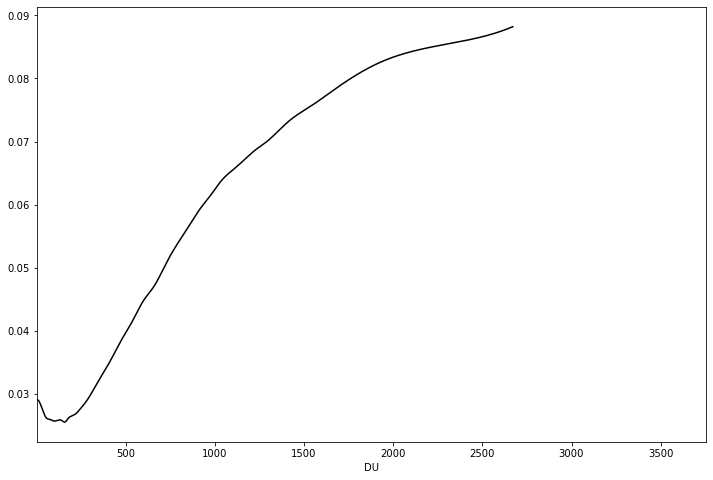

In [14]:
int_plot = df_yield_curve_int.iloc[4535]
int_plot.plot(figsize=(12,8), color = 'black')

#int_plot.savefig('int curve.png', dpi=400)

---
# (2) Estratégia de Carry

## Carry
Cálculo do carry anualizado de se segurar um contrato por 3 meses, para os vértices da curva de 6 meses em 6 meses.

In [15]:
# Dataframe com yield curve para último dia útil da série
df_yield_curve_day = df_yield_curve.loc['2020-05-15'].dropna()
df_yield_curve_int_day = df_yield_curve_int.loc['2020-05-15'].dropna()
df_yield_curve_day

DU
1       0.029000
11      0.029031
32      0.027690
55      0.026270
76      0.026000
97      0.025750
118     0.025850
138     0.025900
160     0.025600
180     0.026220
198     0.026540
221     0.026900
241     0.027510
283     0.029000
348     0.032100
411     0.035100
473     0.038400
535     0.041400
600     0.044800
662     0.047200
725     0.050600
786     0.053600
850     0.056400
911     0.059100
972     0.061310
1035    0.063750
1101    0.065510
1165    0.067100
1226    0.068640
1287    0.069900
1418    0.073300
1540    0.075650
1668    0.078200
1919    0.082450
2168    0.084700
2671    0.088200
Name: 2020-05-15 00:00:00, dtype: float64

In [16]:
# Vetor de vértices de DIs disponíveis na data analisada
vert = df_yield_curve_day.index.values
vert = vert[vert>63]
vert

array([  76,   97,  118,  138,  160,  180,  198,  221,  241,  283,  348,
        411,  473,  535,  600,  662,  725,  786,  850,  911,  972, 1035,
       1101, 1165, 1226, 1287, 1418, 1540, 1668, 1919, 2168, 2671],
      dtype=int64)

In [17]:
# Dataframe com yield curve para os vértices de DIs disponíveis
y_ini = df_yield_curve_int_day[vert].values

# Dataframe com yield curve, começando 3 meses antes do y_ini
y_fim = df_yield_curve_int_day[vert-63].values

# Vetor com o cálculo do carry
carry = (((1+y_ini)**(vert/63))/((1+y_fim)**((vert-63)/63)))-1

# Dataframe do vetor carry
df_carry = pd.DataFrame(carry, index=vert, columns =['Carry'])
df_carry

,Carry
76,0.025389
97,0.024789
118,0.025483
138,0.025771
160,0.025369
180,0.026926
198,0.027852
221,0.030195
241,0.031350
283,0.036449


## Carry ajustado por DV01

In [18]:
PU = 100000/(1+df_yield_curve_int_day[vert])**(vert/252)
dv01 =(vert/252)*PU.values*0.01
dv01
carry_ajust_dv01 = carry/dv01
df_carry_ajust_dv01 = pd.DataFrame(carry_ajust_dv01, index=vert, columns =['Carry Ajust DV01'])
df_carry_ajust_dv01

,Carry Ajust DV01
76,0.000085
97,0.000065
118,0.000055
138,0.000048
160,0.000041
180,0.000038
198,0.000036
221,0.000035
241,0.000034
283,0.000034


## Carry Ajustado por Duration

In [114]:
carry_ajust_dur = carry/(vert/252)
df_carry_ajust_dur = pd.DataFrame(carry_ajust_dur, index=vert, columns =['Carry Ajust Dur'])
df_carry_ajust_dur

,Carry Ajust Dur
76,0.084186
97,0.064400
118,0.054422
138,0.047060
160,0.039956
180,0.037697
198,0.035448
221,0.034431
241,0.032781
283,0.032456


## Estratégia
Tracker dos carry trades ao longo das datas em 2020 e avaliação da performance através do Sharpe.

In [19]:
df_yield_curve_int_tracker = df_yield_curve_int.loc['2020-05-15':]

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2020-05-15,0.029,0.029035,0.029063,0.029082,0.029094,0.0291,0.029098,0.029091,0.029076,0.029057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Melhor Sharpe
j = 76
df_retorno = pd.DataFrame(np.nan, index = df_yield_curve_int_tracker.index, columns =['Retorno'])

for i in np.arange(0,len(df_yield_curve_int_tracker.index)-1):
    y_ant = df_yield_curve_int_tracker.iloc[i,j]
    y = df_yield_curve_int_tracker.iloc[i+1,j-1]
    pu_ant = 100000/((1+y_ant)**(j/252))
    pu = 100000/((1+y)**((j-1)/252))
    df_retorno.iloc[i+1,0] = pu/pu_ant - 1
    j = j - 1
    if j <= 63:
        j = 126

print(df_retorno)
print(df_retorno.cumsum())

print(df_cdi.loc['2020-01-02':'2020-05-15'].cumsum())

df_cdi_bench = df_cdi.loc['2020-01-02':'2020-05-15']

X1 = (1 + np.nanmean(df_retorno.values))**252-1
X2 = (1 + np.nanmean(df_cdi_bench.values))**252-1
X3 = np.nanstd(df_retorno.values, ddof=1)*np.sqrt(252)

Sharpe = (X1-X2)/X3
print(Sharpe)

            Retorno
time_stamp         
2020-05-15      NaN
            Retorno
time_stamp         
2020-05-15      NaN
                 CDI
data                
2020-01-02  0.000171
2020-01-03  0.000342
2020-01-06  0.000513
2020-01-07  0.000684
2020-01-08  0.000854
2020-01-09  0.001025
2020-01-10  0.001196
2020-01-13  0.001367
2020-01-14  0.001538
2020-01-15  0.001709
2020-01-16  0.001880
2020-01-17  0.002051
2020-01-20  0.002222
2020-01-21  0.002392
2020-01-22  0.002563
2020-01-23  0.002734
2020-01-24  0.002905
2020-01-27  0.003076
2020-01-28  0.003247
2020-01-29  0.003418
2020-01-30  0.003589
2020-01-31  0.003760
2020-02-03  0.003930
2020-02-04  0.004101
2020-02-05  0.004272
2020-02-06  0.004434
2020-02-07  0.004595
2020-02-10  0.004756
2020-02-11  0.004918
2020-02-12  0.005079
...              ...
2020-04-01  0.010213
2020-04-02  0.010356
2020-04-03  0.010498
2020-04-06  0.010640
2020-04-07  0.010782
2020-04-08  0.010925
2020-04-09  0.011067
2020-04-13  0.011209
2020-04-14  0.01135

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [21]:
# Maior Retorno Acumulado
j = 76
df_retorno_2 = pd.DataFrame(np.nan, index = df_yield_curve_int_tracker.index, columns =['Retorno'])

for i in np.arange(0,len(df_yield_curve_int_tracker.index)-1):
    y_ant = df_yield_curve_int_tracker.iloc[i,j]
    y = df_yield_curve_int_tracker.iloc[i+1,j-1]
    pu_ant = 100000/((1+y_ant)**(j/252))
    pu = 100000/((1+y)**((j-1)/252))
    df_retorno_2.iloc[i+1,0] = pu/pu_ant - 1
    j = j - 1
    if j <= 1575:
        j = 1638

print(df_retorno_2)
print(df_retorno_2.cumsum())

print(df_cdi.loc['2020-01-02':'2020-05-15'].cumsum())

df_cdi_bench = df_cdi.loc['2020-01-02':'2020-05-15']

Z1 = (1 + np.nanmean(df_retorno_2.values))**252-1
Z2 = (1 + np.nanmean(df_cdi_bench.values))**252-1
Z3 = np.nanstd(df_retorno_2.values, ddof=1)*np.sqrt(252)

Sharpe_2 = (Z1-Z2)/Z3
print(Sharpe_2)

            Retorno
time_stamp         
2020-05-15      NaN
            Retorno
time_stamp         
2020-05-15      NaN
                 CDI
data                
2020-01-02  0.000171
2020-01-03  0.000342
2020-01-06  0.000513
2020-01-07  0.000684
2020-01-08  0.000854
2020-01-09  0.001025
2020-01-10  0.001196
2020-01-13  0.001367
2020-01-14  0.001538
2020-01-15  0.001709
2020-01-16  0.001880
2020-01-17  0.002051
2020-01-20  0.002222
2020-01-21  0.002392
2020-01-22  0.002563
2020-01-23  0.002734
2020-01-24  0.002905
2020-01-27  0.003076
2020-01-28  0.003247
2020-01-29  0.003418
2020-01-30  0.003589
2020-01-31  0.003760
2020-02-03  0.003930
2020-02-04  0.004101
2020-02-05  0.004272
2020-02-06  0.004434
2020-02-07  0.004595
2020-02-10  0.004756
2020-02-11  0.004918
2020-02-12  0.005079
...              ...
2020-04-01  0.010213
2020-04-02  0.010356
2020-04-03  0.010498
2020-04-06  0.010640
2020-04-07  0.010782
2020-04-08  0.010925
2020-04-09  0.011067
2020-04-13  0.011209
2020-04-14  0.01135

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\bwgi\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
